This notebook will be an exploration of training a transformer model on a sequence of colors. The goal is to have the model learn to predict the next color in the sequence. The model will be trained on a sequence of colors and will be evaluated on a sequence of colors that it has never seen before. 


In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import palettable

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[('Accent_3', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C3813061D0>), ('Accent_3_r', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C3813060E0>), ('Accent_4', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C381306230>), ('Accent_4_r', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C381306290>), ('Accent_5', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C3813062F0>), ('Accent_5_r', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C381306350>), ('Accent_6', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C3813063B0>), ('Accent_6_r', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C381306410>), ('Accent_7', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C381306470>), ('Accent_7_r', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C3813064D0>), ('Accent_8', <palettable.colorbrewer.colorbrewer.BrewerMap object at 0x000002C3

ValueError: cannot reshape array of size 1 into shape (3)

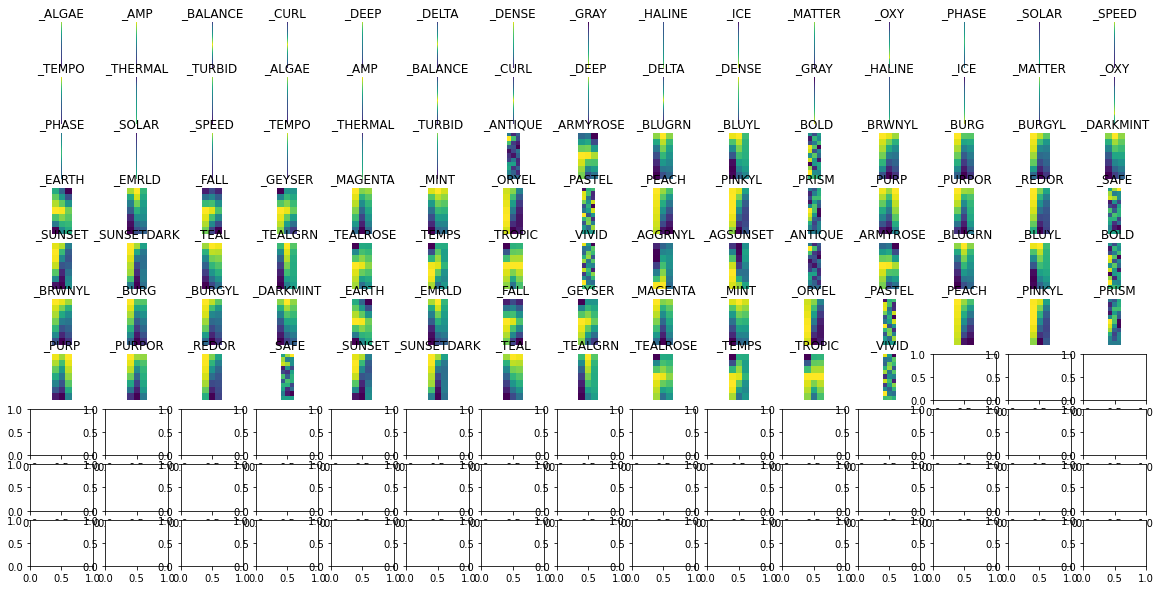

In [2]:
qual_carto_palettes = [(pal,getattr(palettable.cartocolors.qualitative.colormaps,pal)) for pal in dir(palettable.cartocolors.qualitative.colormaps) if not pal.startswith('__')]
seq_carto_palettes = [(pal,getattr(palettable.cartocolors.sequential.colormaps,pal)) for pal in dir(palettable.cartocolors.sequential.colormaps) if not pal.startswith('__')]
div_carto_palettes = [(pal,getattr(palettable.cartocolors.diverging.colormaps,pal)) for pal in dir(palettable.cartocolors.diverging.colormaps) if not pal.startswith('__')]
carto_palettes = qual_carto_palettes + seq_carto_palettes + div_carto_palettes

div_cmocean_palettes = [(pal,getattr(palettable.cmocean.diverging.colormaps,pal)) for pal in dir(palettable.cmocean.diverging.colormaps) if not pal.startswith('__')]
seq_cmocean_palettes = [(pal,getattr(palettable.cmocean.sequential.colormaps,pal)) for pal in dir(palettable.cmocean.sequential.colormaps) if not pal.startswith('__')]
cmocean_palettes = div_cmocean_palettes + seq_cmocean_palettes

qual_colorbrewer_palettes = [(pal,(getattr(palettable.colorbrewer.qualitative,pal))) for pal in dir(palettable.colorbrewer.qualitative) if not pal.startswith('__')]
div_colorbrewer_palettes = [(pal,(getattr(palettable.colorbrewer.diverging,pal))) for pal in dir(palettable.colorbrewer.diverging) if not pal.startswith('__')]
seq_colorbrewer_palettes = [(pal,(getattr(palettable.colorbrewer.sequential,pal))) for pal in dir(palettable.colorbrewer.sequential) if not pal.startswith('__')]
colorbrewer_palettes = qual_colorbrewer_palettes + div_colorbrewer_palettes + seq_colorbrewer_palettes
print(colorbrewer_palettes)

div_lightbartlein_palettes = [(pal,getattr(palettable.lightbartlein.diverging.colordata,pal)) for pal in dir(palettable.lightbartlein.diverging.colordata) if not pal.startswith('__')]
seq_lightbartlein_palettes = [(pal,getattr(palettable.lightbartlein.sequential.colordata,pal)) for pal in dir(palettable.lightbartlein.sequential.colordata) if not pal.startswith('__')]
lightbartlein_palettes = div_lightbartlein_palettes + seq_lightbartlein_palettes

all_palettes = carto_palettes + cmocean_palettes +lightbartlein_palettes# +colorbrewer_palettes

fig, ax = plt.subplots(10,15,figsize=(20,10))
for i, (name, pal) in enumerate(carto_palettes):
    ax[i//15,i%15].imshow(np.array(pal).reshape(-1,3))
    ax[i//15,i%15].set_title(name)
    ax[i//15,i%15].axis('off')

for i, (name, pal) in enumerate(cmocean_palettes):
    ax[i//15,i%15].imshow(np.array(pal).reshape(-1,3))
    ax[i//15,i%15].set_title(name)
    ax[i//15,i%15].axis('off')

for i, (name, pal) in enumerate(colorbrewer_palettes):
    ax[i//15,i%15].imshow(np.array(pal).reshape(-1,3))
    ax[i//15,i%15].set_title(name)
    ax[i//15,i%15].axis('off')

for i, (name, pal) in enumerate(lightbartlein_palettes):
    ax[i//15,i%15].imshow(np.array(pal).reshape(-1,3))
    ax[i//15,i%15].set_title(name)
    ax[i//15,i%15].axis('off')
    
plt.show()



In [ ]:
print([getattr(palettable, x) for x in dir(palettable) if hasattr(getattr(palettable, x), '_palettes')])
plt.figure(figsize=(10,1))
plt.imshow(np.array(wes.Zissou_5.colors).reshape(1,-1,3))
plt.axis('off')
plt.show()

[<module 'palettable.wesanderson' from 'c:\\Python310\\lib\\site-packages\\palettable\\wesanderson\\__init__.py'>]


NameError: name 'wes' is not defined

<Figure size 720x72 with 0 Axes>

In [3]:
# now lets make a torch dataset that will return a batch of swatches 
# we will use the Zissou palette
class ColorSwatchDataset(torch.utils.data.Dataset):
    def __init__(self, palette_names:list, colors:list, swatch_size:int):
        self.palette_names = []
        self.colors = []
        self.swatch_size = swatch_size
        for i in range(len(colors)):
            # check that the palette is long enough, then truncate 
            if len(colors[i]) < self.swatch_size:
                print(f'Palette {palette_names[i]} is too short, passing')
                continue
            else:
                self.palette_names.append(palette_names[i])
                self.colors.append(colors[i][:self.swatch_size])
        print(self.colors)
        self.colors = torch.tensor(self.colors, dtype=torch.float32)
        self.colors = self.colors / 255.0 

    def __len__(self):
        return len(self.palette_names)
    
    def __getitem__(self, idx):
        return self.colors[idx] # return a single color swatch

In [4]:
colorSwatchData = ColorSwatchDataset([x[0] for x in all_palettes], [x[1] for x in all_palettes], 6)

[[[36, 86, 104], [15, 114, 121], [13, 143, 129], [57, 171, 126], [110, 197, 116], [169, 220, 103]], [[75, 41, 145], [135, 44, 162], [192, 54, 157], [234, 79, 136], [250, 120, 118], [246, 169, 122]], [[133, 92, 117], [217, 175, 107], [175, 100, 88], [115, 111, 76], [82, 106, 131], [98, 83, 119]], [[121, 130, 52], [163, 173, 98], [208, 211, 162], [253, 251, 228], [240, 198, 195], [223, 145, 163]], [[196, 230, 195], [150, 210, 164], [109, 188, 144], [77, 162, 132], [54, 135, 122], [38, 107, 110]], [[247, 254, 174], [183, 230, 165], [124, 203, 162], [70, 174, 160], [8, 144, 153], [0, 113, 139]], [[127, 60, 141], [17, 165, 121], [57, 105, 172], [242, 183, 1], [231, 63, 116], [128, 186, 90]], [[237, 229, 207], [224, 194, 162], [211, 156, 131], [193, 118, 111], [166, 84, 97], [129, 55, 83]], [[255, 198, 196], [244, 163, 168], [227, 129, 145], [204, 96, 125], [173, 70, 108], [139, 48, 88]], [[251, 230, 197], [245, 186, 152], [238, 138, 130], [220, 113, 118], [200, 88, 108], [156, 63, 93]], [[2

In [5]:
print(len(colorSwatchData))

170


In [6]:
# now lets make a dataloader to load the data
colorSwatchLoader = torch.utils.data.DataLoader(colorSwatchData, batch_size=16, shuffle=True)

# now lets make a function to show the swatches
def showSwatches(swatch_batch):
    plt.figure(figsize=(20,10))
    for i in range(swatch_batch.shape[0]):
        plt.subplot(1,swatch_batch.shape[0],i+1)
        plt.imshow(swatch_batch[i].numpy().reshape(1,-1,3))
        plt.axis('off')
    plt.show()

# now lets get a batch of swatches and show them
for swatch_batch in colorSwatchLoader:
    showSwatches(swatch_batch)
    break

In [7]:
# Lets make a transformer-based model to predict the next color in the swatch
# using torch.nn.Transformer

class SwatchTransformer(torch.nn.Module):
    def __init__(self, hidden_size, num_layers, num_heads, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout = dropout
        self.embedding = torch.nn.Linear(3, 32)
        self.transformer = torch.nn.Transformer(d_model=32, nhead=self.num_heads, num_encoder_layers=self.num_layers, num_decoder_layers=self.num_layers, dim_feedforward=self.hidden_size, dropout=self.dropout)
        self.fc = torch.nn.Linear(32, 3)

    def make_square_mask(self, size):
        '''Makes a mask that has -inf on the upper triangle and 0 everywhere else'''
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask
    
    def forward(self, src, tgt, mask=None):
        # x is a batch of swatches, shape (batch_size, num_colors, 3)
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)
        # now x is shape (num_colors, batch_size, 3)
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        # now x is shape (num_colors, batch_size, 64)
        trans_output = self.transformer(src,tgt, tgt_mask=mask)
        # now x is shape (num_colors, batch_size, 3)
        output = self.fc(trans_output)
        # now x is shape (num_colors, batch_size, 3)
        output = output.permute(1,0,2)
        # now x is shape (batch_size, num_colors, 3)
        return output

In [8]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [9]:
from torchsummary import summary

# now lets make a function to train the model
def trainSwatchTransformer(model, dataloader, num_epochs, predicted_palettes=None, lr=0.0001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    for epoch in range(num_epochs):
        for swatch_batch in dataloader:
            input_seq = swatch_batch
            target_seq = swatch_batch[:,:-1,:] # shift the target sequence by one to the left, so the model has to predict the next color
            target_output_seq = swatch_batch[:,1:,:] # shift the target output sequence by one to the right, so the model has to predict the next color
            mask = model.make_square_mask(target_seq.shape[1])
            optimizer.zero_grad()
            pred = model(input_seq, target_seq, mask=mask)
            loss = loss_fn(pred, target_output_seq)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            if predicted_palettes is not None:
                with torch.no_grad():
                    test_input = palettable.wesanderson.Zissou_5.colors
                    test_input = torch.tensor(test_input, dtype=torch.float32)
                    test_input = test_input / 255.0
                    test_input = test_input.reshape(1,5,3)
                    mask = model.make_square_mask(5)
                    pred = model(test_input, test_input, mask=mask)
                    pred = pred.reshape(5,3)
                    pred = pred * 255.0
                    pred = pred.detach().numpy()
                    predicted_palettes.append(pred)
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# now lets make a model and train it
swatchTransformer = SwatchTransformer(64, 3, 8)
# print a summary of the model

count_parameters(swatchTransformer)
predicted_palettes = [] # this will hold the predicted palettes for each epoch of training where we are basing it on the Zissou palette
trainSwatchTransformer(swatchTransformer, colorSwatchLoader, 1000, predicted_palettes)




+-------------------------------------------------------------+------------+
|                           Modules                           | Parameters |
+-------------------------------------------------------------+------------+
|                       embedding.weight                      |     96     |
|                        embedding.bias                       |     32     |
|    transformer.encoder.layers.0.self_attn.in_proj_weight    |    3072    |
|     transformer.encoder.layers.0.self_attn.in_proj_bias     |     96     |
|    transformer.encoder.layers.0.self_attn.out_proj.weight   |    1024    |
|     transformer.encoder.layers.0.self_attn.out_proj.bias    |     32     |
|         transformer.encoder.layers.0.linear1.weight         |    2048    |
|          transformer.encoder.layers.0.linear1.bias          |     64     |
|         transformer.encoder.layers.0.linear2.weight         |    2048    |
|          transformer.encoder.layers.0.linear2.bias          |     32     |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


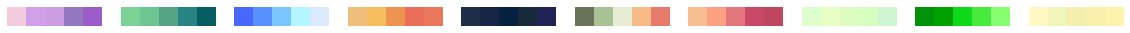

Actual


In [13]:
with torch.no_grad():
    # now lets see how the model does
    for swatch_batch in colorSwatchLoader:
        mask = swatchTransformer.make_square_mask(swatch_batch.shape[1]-1)
        pred = swatchTransformer(swatch_batch, swatch_batch[:,:-1,:], mask=mask)
        print("Predicted")
        showSwatches(pred)
        print("Actual")
        showSwatches(swatch_batch)


Predicted


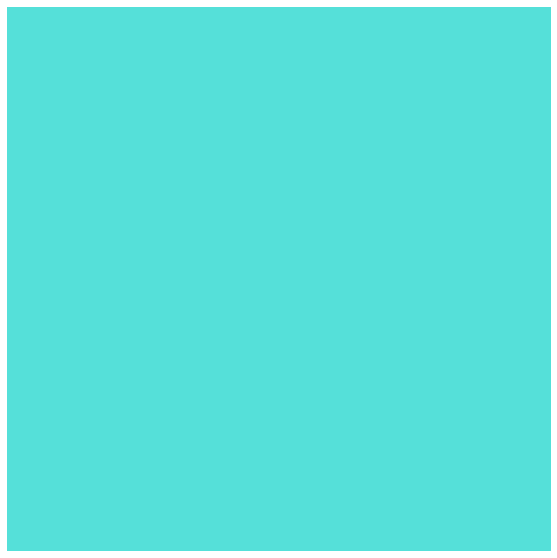

Actual


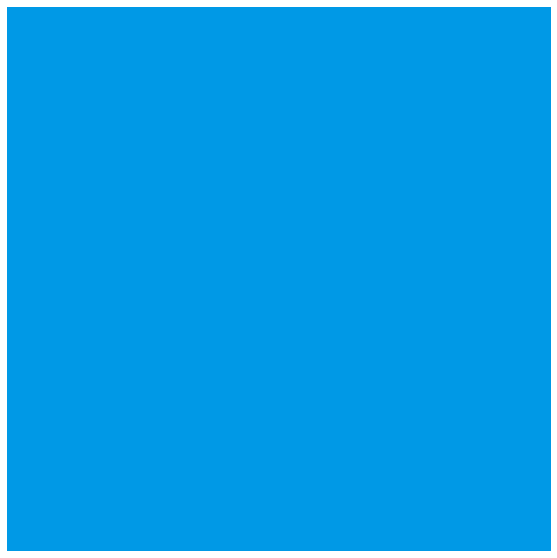

In [15]:
# Now lets make a single color and see how the model predicts the next color
# we will use the Zissou palette
with torch.no_grad():
    color = torch.tensor(palettable.wesanderson.Zissou_5.colors[0], dtype=torch.float32) / 255.0
    color = color.reshape(1,1,3)
    pred = swatchTransformer(color, color)
    print("Predicted")
    showSwatches(pred)
    print("Actual")
    showSwatches(color)

Predicted


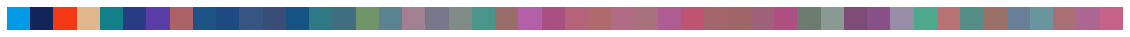

Actual


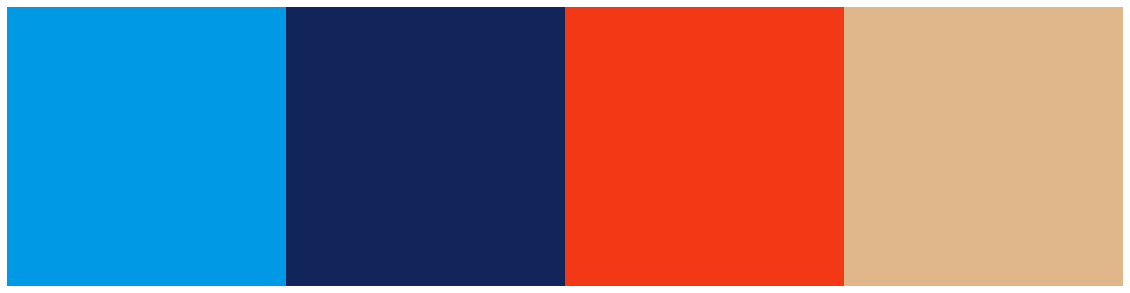

In [16]:
# now lets make an animation of the model predicting the next color then the next color, etc.
# we will use the Zissou palette
with torch.no_grad():
    color = torch.tensor(palettable.wesanderson.Zissou_5.colors[0:4], dtype=torch.float32) / 255.0
    color = color.reshape(1,-1,3)
    pred = swatchTransformer(color, color)
    pred = pred.reshape(1,-1,3)
    pred = torch.cat((color, pred), dim=1)
    for i in range(10):
        pred = swatchTransformer(color, pred)
        pred = pred.reshape(1,-1,3)
        pred = torch.cat((color, pred), dim=1)
    print("Predicted")
    showSwatches(pred)
    print("Actual")
    showSwatches(color)

c:\Python310\lib\site-packages\colour\utilities\verbose.py:266: ColourUsageWarning: The "ALEXA Wide Gamut" RGB colourspace has been renamed to "ARRI Wide Gamut 3" for consistency with ARRI's new naming convention.
  warn(*args, **kwargs)
c:\Python310\lib\site-packages\colour\utilities\verbose.py:266: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)
c:\Python310\lib\site-packages\colour\utilities\verbose.py:266: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)


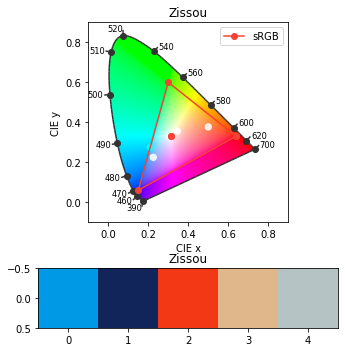

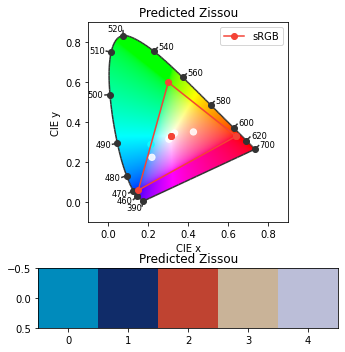

In [17]:
from colour import plotting

def plot_palette_w_chromaticity_diagram(palette, title=None, axes_palette=None, axes_chroma=None):
    if axes_palette is None or axes_chroma is None:
        fig, axes = plt.subplots(2,1, figsize=(10,5), height_ratios=[1,0.3])
        axes_palette = axes[1]
        axes_chroma = axes[0]
    plotting.plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(palette, standalone=False, axes=axes_chroma, title=title)
    axes_palette.imshow(np.array([palette], dtype=np.uint8))
    if title is not None:
        axes_palette.set_title(title)

plot_palette_w_chromaticity_diagram(palettable.wesanderson.Zissou_5.colors, title="Zissou")
plt.show()
# predict the next color in the Zissou palette
predicted_palette = []
with torch.no_grad():
    for color in palettable.wesanderson.Zissou_5.colors:
        color = torch.tensor(color, dtype=torch.float32) / 255.0
        color = color.reshape(1,1,3)
        pred = swatchTransformer(color, color)
        pred = pred.reshape(3)
        pred = pred.numpy()
        pred = pred * 255.0
        pred = pred.astype(int)
        predicted_palette.append(pred)

plot_palette_w_chromaticity_diagram(predicted_palette, title="Predicted Zissou")
plt.show()




In [18]:
def plot_palette_w_chromaticity_diagram_against_color_swatch(colorswatch, palette, title=None, fig=None, axes=None):
    if fig is None or axes is None:
        fig, axes = plt.subplots(2,2, figsize=(10,5), height_ratios=[1,0.3])
    plot_palette_w_chromaticity_diagram(palette, title=f"Predicted {title}", axes_palette=axes[1,1], axes_chroma=axes[0,1])
    plot_palette_w_chromaticity_diagram(colorswatch, title=title, axes_palette=axes[1,0], axes_chroma=axes[0,0])

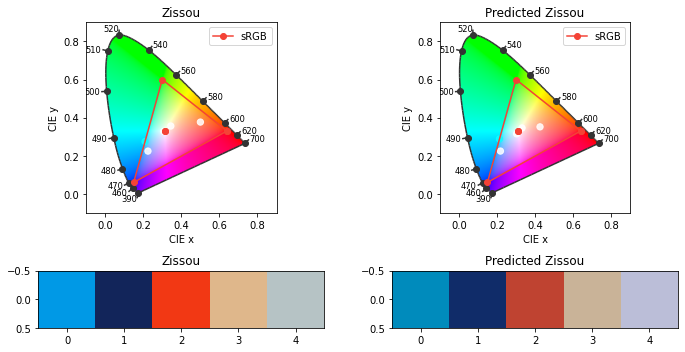

In [19]:
plot_palette_w_chromaticity_diagram_against_color_swatch(palettable.wesanderson.Zissou_5.colors, predicted_palette, title="Zissou")

Animating frame 0.00
Animating frame 0.00
Animating frame 0.33
Animating frame 0.67
Animating frame 1.00
Animating frame 1.33
Animating frame 1.67
Animating frame 2.00
Animating frame 2.33
Animating frame 2.67
Animating frame 3.00
Animating frame 3.33
Animating frame 3.67
Animating frame 4.00
Animating frame 4.33
Animating frame 4.67
Animating frame 5.00
Animating frame 5.33
Animating frame 5.67
Animating frame 6.00
Animating frame 6.33
Animating frame 6.67
Animating frame 7.00
Animating frame 7.33
Animating frame 7.67
Animating frame 8.00
Animating frame 8.33
Animating frame 8.67
Animating frame 9.00
Animating frame 9.33
Animating frame 9.67
Animating frame 10.00
Animating frame 10.33
Animating frame 10.67
Animating frame 11.00
Animating frame 11.33
Animating frame 11.67
Animating frame 12.00
Animating frame 12.33
Animating frame 12.67
Animating frame 13.00
Animating frame 13.33
Animating frame 13.67
Animating frame 14.00
Animating frame 14.33
Animating frame 14.67
Animating frame 15.

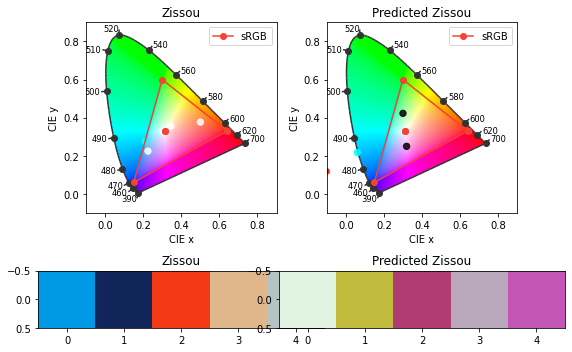

In [ ]:
from matplotlib import animation
from functools import partial

def animate_learning_predictions(frame_no, fig, axes):
    '''
    Take the predicted palettes accumulated during training and animate them
    ''' 
    # clear all the axes so we can redraw them
    for ax in fig.axes:
        ax.cla()

    global predicted_palettes
    print(f"Animating frame {frame_no/len(predicted_palettes)*100:.2f}")
    current_predicted_palette = predicted_palettes[frame_no]
    plot_palette_w_chromaticity_diagram_against_color_swatch(palettable.wesanderson.Zissou_5.colors, current_predicted_palette, title="Zissou", fig=fig, axes=axes)

# now lets make an animation of the model predicting the next color then the next color, etc.
# we will use the Zissou palette
fig, axes= plt.subplots(2,2, figsize=(10,5), height_ratios=[1,0.3])
anim = animation.FuncAnimation(fig, partial(animate_learning_predictions, fig=fig, axes=axes), frames=len(predicted_palettes), interval=100, blit=False)
anim.save("learning_palette.gif", dpi=128)

In [10]:
# save the model as an ONNX file 
import torch.onnx

sample_src_input, sample_tgt_input = torch.randn(1, 1, 3, requires_grad=True), torch.randn(1, 5, 3, requires_grad=True)
torch_out = swatchTransformer(sample_src_input, sample_tgt_input )

torch.onnx.export(swatchTransformer, (sample_src_input, sample_tgt_input), "swatchTransformer_fiveColor.onnx", export_params=True, opset_version=10, do_constant_folding=True, input_names=['input_src', 'input_tgt'], output_names=['output'], dynamic_axes={'input': {0:"batch_size", 1:"palette_size"}, 'output': {0:"batch_size", 1:"palette_size"}})


c:\Python310\lib\site-packages\torch\onnx\utils.py:1514: UserWarning: Provided key input for dynamic axes is not a valid input/output name
  warnings.warn(


In [11]:
import onnx

onnx_model = onnx.load("swatchTransformer_fiveColor.onnx")
onnx.checker.check_model(onnx_model)

In [31]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("swatchTransformer.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(sample_src_input), ort_session.get_inputs()[1].name: to_numpy(sample_tgt_input)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 3 / 3 (100%)
Max absolute difference: 0.15268763899803162
Max relative difference: 6.732571601867676
 x: array([[[ 0.07329 ,  0.136381,  0.461457]]], dtype=float32)
 y: array([[[ 0.009478,  0.12239 ,  0.308769]]], dtype=float32)